In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [12]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [13]:
class Net(nn.Module):
    def __init__(self, activation):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.activation = activation

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
def relu(x):
    return torch.max(torch.zeros_like(x), x)

def gelu(x):
    cdf = 0.5 * (1.0 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))
    return x * cdf

def swish(x):
    return x * (1 / (1 + torch.exp(-x)))

def softplus(x):
    return torch.log(1 + torch.exp(x))

In [15]:
def train_net(net, criterion, optimizer, epochs=10):
    losses = []
    accuracies = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        losses.append(running_loss / len(trainloader))
        accuracies.append(100 * correct / total)
        print(f'Epoch {epoch + 1}, Loss: {losses[-1]:.3f}, Accuracy: {accuracies[-1]:.2f}%')
    return losses, accuracies

In [16]:
def test_net(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy on test set: {100 * correct / total:.2f}%')

In [17]:
activations = {'ReLU': relu, 'GELU': gelu, 'Swish': swish, 'Softplus': softplus}
all_losses = {}
all_accuracies = {}

for name, activation in activations.items():
    print(f'Training with {name} activation...')
    net = Net(activation)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    losses, accuracies = train_net(net, criterion, optimizer)
    all_losses[name] = losses
    all_accuracies[name] = accuracies
    test_net(net)

Training with ReLU activation...
Epoch 1, Loss: 0.399, Accuracy: 88.29%
Epoch 2, Loss: 0.190, Accuracy: 94.26%
Epoch 3, Loss: 0.136, Accuracy: 95.89%
Epoch 4, Loss: 0.110, Accuracy: 96.61%
Epoch 5, Loss: 0.094, Accuracy: 97.08%
Epoch 6, Loss: 0.084, Accuracy: 97.36%
Epoch 7, Loss: 0.075, Accuracy: 97.54%
Epoch 8, Loss: 0.068, Accuracy: 97.83%
Epoch 9, Loss: 0.062, Accuracy: 98.01%
Epoch 10, Loss: 0.057, Accuracy: 98.13%
Accuracy on test set: 97.16%
Training with GELU activation...
Epoch 1, Loss: 0.338, Accuracy: 90.00%
Epoch 2, Loss: 0.157, Accuracy: 95.33%
Epoch 3, Loss: 0.118, Accuracy: 96.30%
Epoch 4, Loss: 0.095, Accuracy: 97.03%
Epoch 5, Loss: 0.082, Accuracy: 97.47%
Epoch 6, Loss: 0.071, Accuracy: 97.75%
Epoch 7, Loss: 0.065, Accuracy: 97.94%
Epoch 8, Loss: 0.056, Accuracy: 98.18%
Epoch 9, Loss: 0.054, Accuracy: 98.21%
Epoch 10, Loss: 0.046, Accuracy: 98.44%
Accuracy on test set: 97.51%
Training with Swish activation...
Epoch 1, Loss: 0.340, Accuracy: 89.56%
Epoch 2, Loss: 0.152,

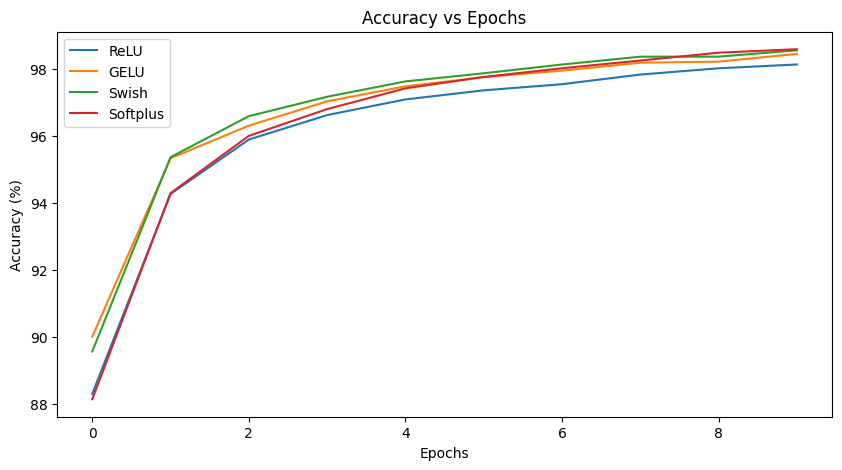

In [18]:
plt.figure(figsize=(10, 5))
for name, accuracies in all_accuracies.items():
    plt.plot(accuracies, label=name)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()